<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scipy.stats as st
import matplotlib as mp
import matplotlib.pyplot as plt

RANDOM_STATE = 41

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv' ,index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
display(data)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data_analisis = data.copy()
data_hours = data_analisis.resample('1H').sum()
data_days = data_analisis.resample('1D').sum()
data_months = data_analisis.resample('1M').sum()

Нам предоставлены данные с марта по август 2018-го года. Качество данных хорошее.

## Анализ

<AxesSubplot:xlabel='datetime'>

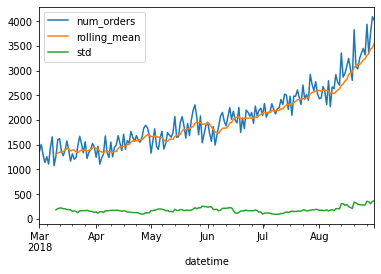

In [5]:
data_days_copy = data_days.copy()
data_days_copy['rolling_mean'] = data_days_copy.rolling(10).mean() 
data_days_copy['std'] = data_days_copy['num_orders'].rolling(10).std()
data_days_copy.plot()

In [6]:
decomposed = seasonal_decompose(data_days, period=7)
data_hours_dec = data_hours.copy()
data_hours_dec = data_hours_dec['2018-03-01':'2018-03-03']
decomposed_2 = seasonal_decompose(data_hours_dec, period=24)

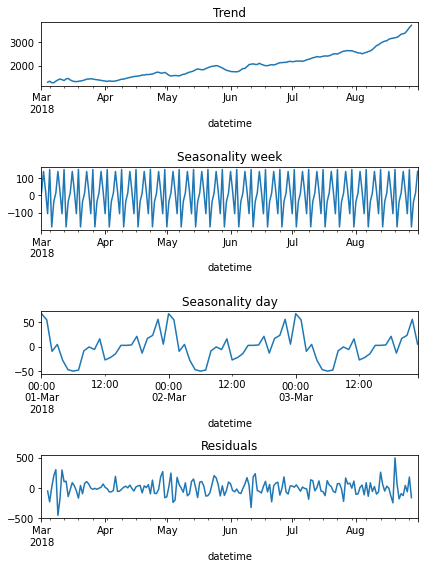

In [7]:
plt.figure(figsize=(6, 8))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality week')
plt.subplot(413)
decomposed_2.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality day')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По анализу временного ряда можно сделать следующие выводы:
- Тренд идет вверх, следовательно количество заказов с каждым месяцем повышается.
- Разброс остатков достаточно велик, значит спрос не постоянен. К концу график увеличивается это говорит о том, что модели может быть сложно научиться на данных и в метрики тренировочной и тестовой выборки могут значительно отличаться.
- Также в спросе ярко выражены как недельная так и суточная сезонности. Суточная ожидаемо приходится на ночное время, недельная конец недели и выходные.

## Обучение
<a id='1-topoc'></a>

In [8]:
# data_ml = data_hours.copy()
# data_ml['year'] = pd.DatetimeIndex(data_ml.index).year
# data_ml['month'] = pd.DatetimeIndex(data_ml.index).month
# data_ml['day'] = pd.DatetimeIndex(data_ml.index).day
# data_ml['hour'] = pd.DatetimeIndex(data_ml.index).hour

In [9]:
def make_features(df, max_lag):
    df['dayofweek'] = df.index.dayofweek
#     df['dayofweek_lag'] = df['num_orders'].shift(168)
    df['day'] = df.index.day
#     df['day_lag'] = df['num_orders'].shift(24)
    df['hour'] = df.index.hour
    df['rolling_mean'] = df['num_orders'].shift().rolling(12).mean()
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    

data_ml = data_hours.copy()
make_features(data_ml, 168)
data_ml = data_ml.reset_index(drop=True)

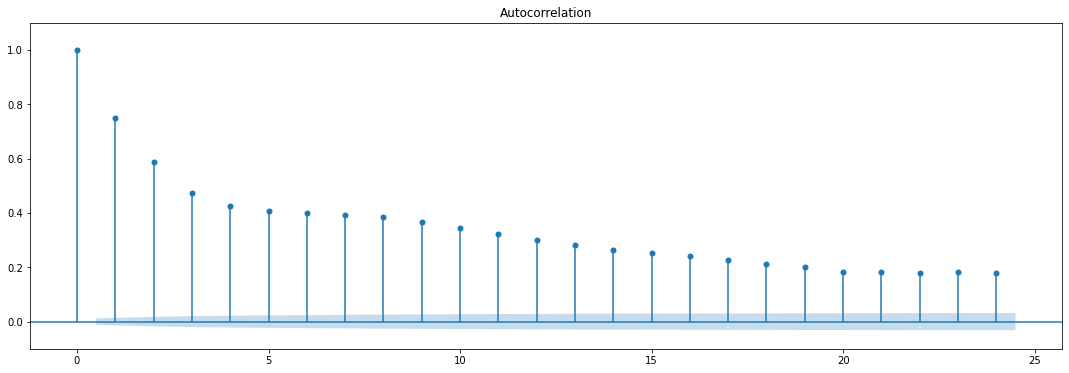

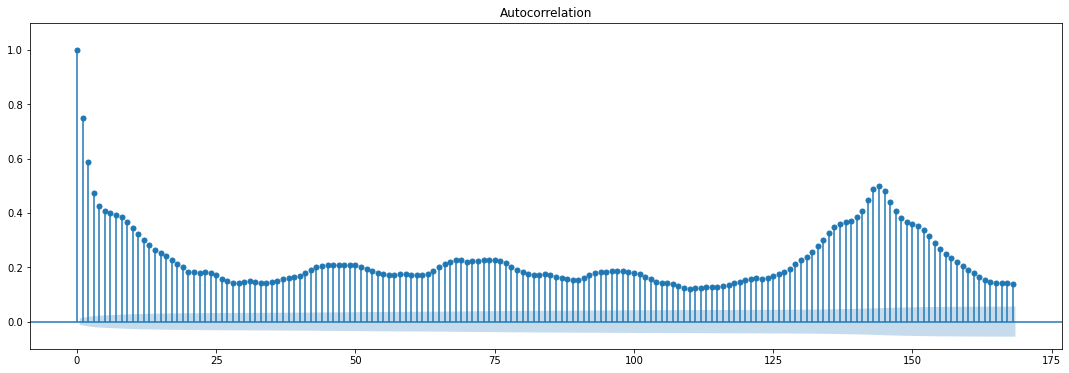

In [10]:
# Код ревьюера (Украдено)
from statsmodels.graphics import tsaplots

# taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
data_isho = data.copy()
data_isho = data_isho['num_orders']

fig = tsaplots.plot_acf(data_isho,lags= 24)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

fig = tsaplots.plot_acf(data_isho,lags= 168)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ml.drop('num_orders', axis=1), 
    data_ml['num_orders'],
    shuffle=False,
    test_size = 0.1,
    random_state=RANDOM_STATE
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent'
) 

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [13]:
param_grid = [

    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2,5),
        'models__min_samples_split': range(2,5),
        'models__min_samples_leaf': range(1,5)
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
    }
]

In [14]:
pipe_final = Pipeline([
    ('models', LinearRegression())
])

In [15]:
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [16]:
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', -grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LinearRegression())])
Метрика лучшей модели, полученная с помощью кросс-валидации: 22.618589530051743


В результате построения модели машинного обучения лучший результат дала линейная регрессия среднее отклонение результатов составляет 22 и не превышает 48, что соответствует техническому заданию

## Тестирование

In [17]:
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 34.55249698829419


На тестовой выборке результаты несколько ухудшились из-за того что разброс данных к концу временного периода значительно увеличивается.